# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters

In [2]:
satellite = "landsat-8-c2-l2"
# satellite = "sentinel-2-l2a"

# bands = "2-3-4"
# bands = "2-3-4-8"
bands = "1-2-3-4-5-6-7"

country_code = "ZMB"

points = "4"
# points = "15"
# points = "24"
# points = "42"

num_features = "1000"

feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights{points}k-points')

year_start = 2013
year_end = 2018

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 20
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [5]:
list(set(crop_districts) - set(country_districts))

['Mafinga', 'Ikelenge']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [10]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather")
    
    if (yr == 2013) & (satellite == "landsat-8-c2-l2"):
        features_x = features_x[features_x.month > 9]
    elif (yr == 2015) & (satellite == "sentinel-2-l2a"):
        features_x = features_x[features_x.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2013.feather
feature.shape (5078, 1004)
Appending: 2013

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2014.feather
feature.shape (32019, 1004)
Appending: 2014

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2015.feather
feature.shape (62534, 1004)
Appending: 2015

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2016.feather
feature.shape (92642, 1004)
Appending: 2016

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2017.feather
feature.shape (117275, 1004)
Appending: 2017

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_4k-points_1000-features_2018.feather
feature.shape (145853, 1004)
Appending: 2018



In [11]:
features = features_raw.copy()

In [12]:
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

In [13]:
# features = features[features.month.isin([5, 6, 7, 8])]

In [14]:
# Here we pivot the data from long format to wide by indexing on 
# 'lon','lat', "year", 'month' and using the unstack function
features = features.set_index(['lon','lat', "year", 'month']).unstack()

# We then map column names based on the month index and the associated features
# so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

In [15]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
impute_data = True
# impute_data = False

if impute_data:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()
else:
    features = features.fillna(0)

In [17]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat)
    , crs='EPSG:4326'
)#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat']) # Optionally attach weight to each point (% area cropped of surrounding 1 km^2)
# Drop lon and lat now that they are in geometry column
features = features.drop(['lon', 'lat'], axis = 1)

In [18]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

In [19]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')

In [20]:
# features

In [21]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

In [22]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
features_gdf = features.copy()
features = features.drop(['geometry'], axis = 1)

In [23]:
# features

In [24]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

In [25]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [26]:
features_summary = (features_summary
                    .set_index(["district", "year"])
                    .join(other = crop_df_x.set_index(["district", "year"]))
                    .reset_index())
# features_summary

In [27]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [28]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

## Model

In [29]:
# features_summary = features_summary[features_summary.year == 2015]
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [31]:
len(y_all)

360

In [32]:
len(x_train)

288

In [33]:
len(x_test)

72

In [34]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [35]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.39


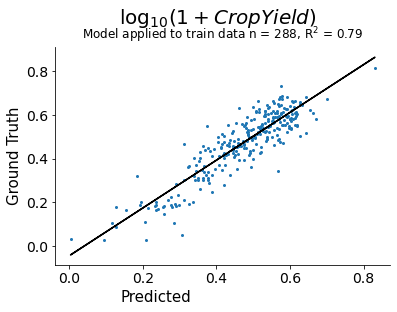

In [36]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [37]:
r2_score(y_train, y_pred)

0.7942421828341875

In [38]:
pearsonr(y_pred, y_train)

(0.8945967324668824, 4.725060518193974e-102)

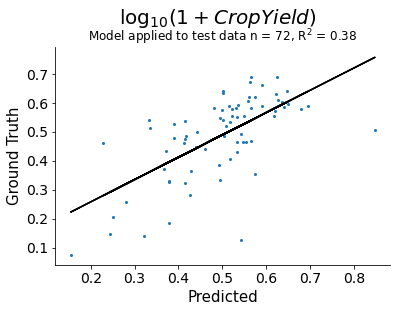

In [39]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [40]:
r2_score(y_test, y_pred)

0.38036882221744406

In [41]:
pearsonr(y_pred, y_test) 

(0.6497247266332322, 6.621210120242517e-10)

In [42]:
pred_features = features.copy()
pred_features['geometry'] = features_gdf['geometry']
pred_features = geopandas.GeoDataFrame(pred_features)
x_all = pred_features.drop([
    'year', 
    'district',
    'geometry', 
#     'yield_mt'
                           ], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [43]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

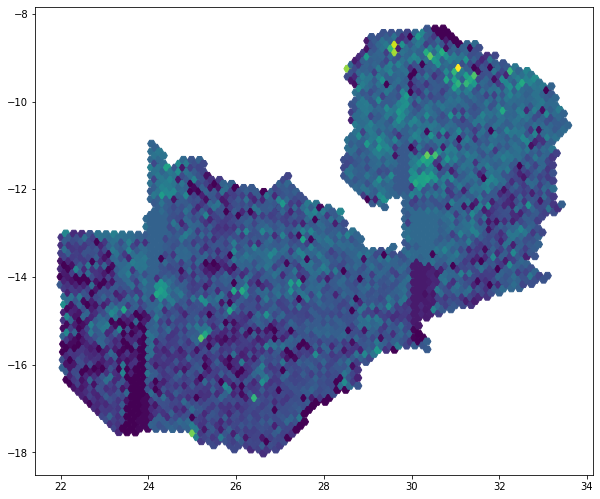

In [44]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   # legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

In [45]:
# true_yield_2018 = residual_gdf[residual_gdf.year == 2018]['log_yield']
# residual_2018 = residual_gdf[residual_gdf.year == 2018]['residual']

# plt.figure()

# p = sns.jointplot(x=true_yield_2018, y = residual_2018).set_axis_labels("True Yield", "Residuals")
# # p.axhline(0)
# plt.suptitle("Plot of Yield vs Residuals 2018",
#           fontsize=12, y=1)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()
# plt.close()

## Yield and Residual Plots

In [46]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["log_yield"].mean()
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["prediction"].mean()
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

Text(0.5, 1.0, '2018 Yield (MT)')

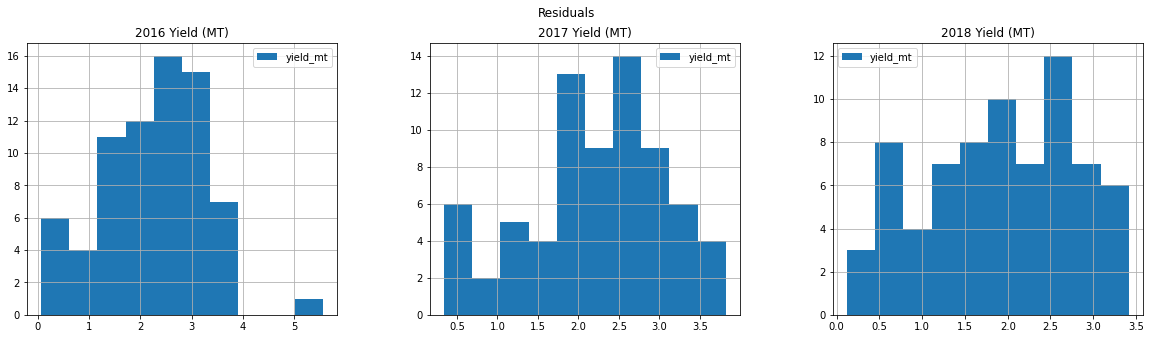

In [47]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plt.suptitle("Residuals")
plt.ax1 = residual_gdf[residual_gdf.year == 2016].hist(ax = ax1, column = "yield_mt", legend = True)
ax1.set_title("2016 Yield (MT)")
plt.ax2 = residual_gdf[residual_gdf.year == 2017].hist(ax = ax2, column = "yield_mt", legend = True) 
ax2.set_title("2017 Yield (MT)")
plt.ax3 = residual_gdf[residual_gdf.year == 2018].hist(ax = ax3, column = "yield_mt", legend = True)
ax3.set_title("2018 Yield (MT)")

Text(0.5, 1.0, '2018 $\\log_{10}(1 + Crop Yield)$')

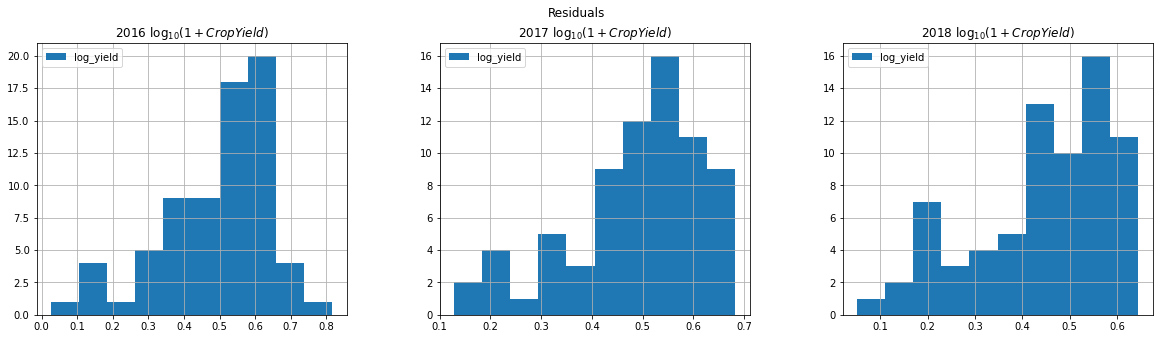

In [48]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plt.suptitle("Residuals")
plt.ax1 = residual_gdf[residual_gdf.year == 2016].hist(ax = ax1, column = "log_yield", legend = True)
ax1.set_title(r"2016 $\log_{10}(1 + Crop Yield)$")
plt.ax2 = residual_gdf[residual_gdf.year == 2017].hist(ax = ax2, column = "log_yield", legend = True) 
ax2.set_title(r"2017 $\log_{10}(1 + Crop Yield)$")
plt.ax3 = residual_gdf[residual_gdf.year == 2018].hist(ax = ax3, column = "log_yield", legend = True)
ax3.set_title(r"2018 $\log_{10}(1 + Crop Yield)$")

Text(0.5, 1.0, 'Plot of $\\log_{10}(1 + Crop Yield)$ vs Residuals 2018')

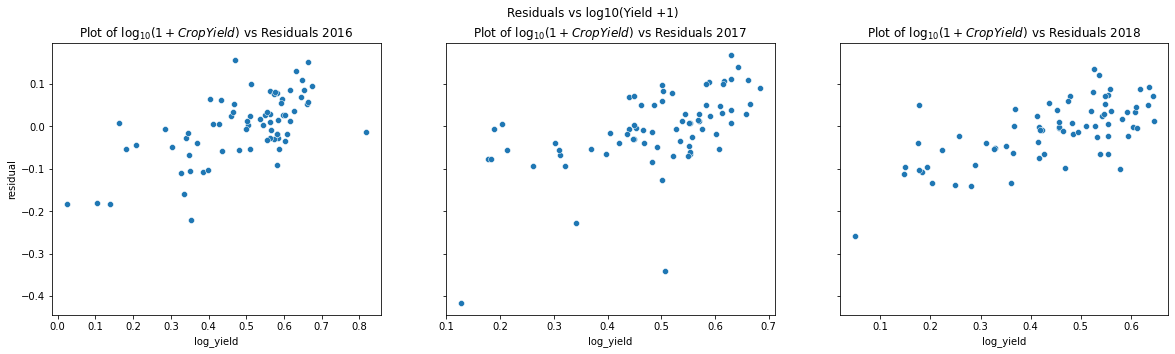

In [49]:
true_yield_2016 = residual_gdf[residual_gdf.year == 2016]['log_yield']
residual_2016 = residual_gdf[residual_gdf.year == 2016]['residual']

true_yield_2017 = residual_gdf[residual_gdf.year == 2017]['log_yield']
residual_2017 = residual_gdf[residual_gdf.year == 2017]['residual']

true_yield_2018 = residual_gdf[residual_gdf.year == 2018]['log_yield']
residual_2018 = residual_gdf[residual_gdf.year == 2018]['residual']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Residuals vs log10(Yield +1)')

sns.scatterplot(ax=ax1, x=true_yield_2016, y = residual_2016)
ax1.set_title(r"Plot of $\log_{10}(1 + Crop Yield)$ vs Residuals 2016")

sns.scatterplot(ax=ax2, x=true_yield_2017, y = residual_2017)
ax2.set_title(r"Plot of $\log_{10}(1 + Crop Yield)$ vs Residuals 2017")

sns.scatterplot(ax=ax3, x=true_yield_2018, y = residual_2018)
ax3.set_title(r"Plot of $\log_{10}(1 + Crop Yield)$ vs Residuals 2018")

Text(0.5, 0.01, 'A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction')

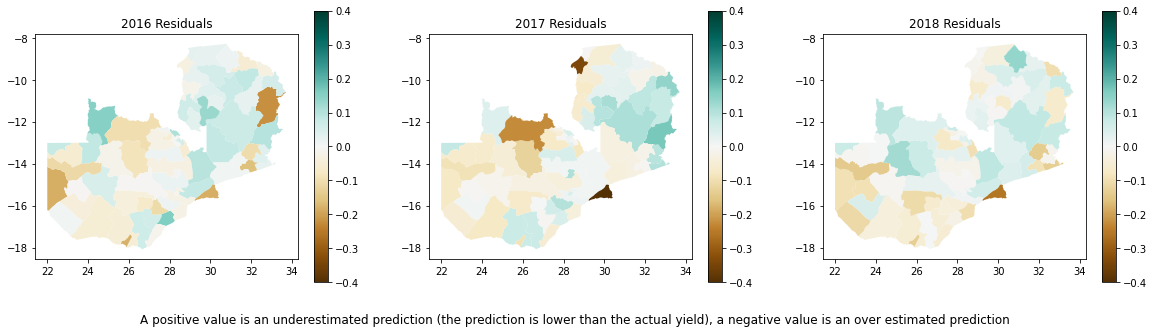

In [50]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, 1.0, '2018 Residuals')

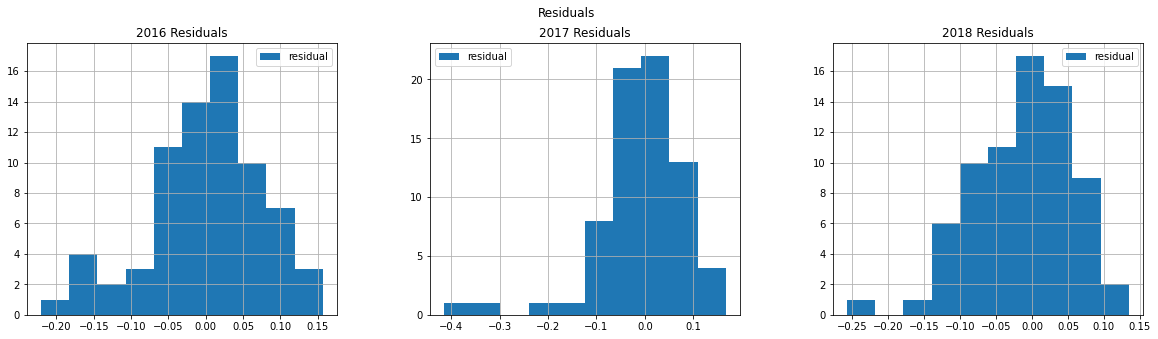

In [51]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plt.suptitle("Residuals")
plt.ax1 = residual_gdf[residual_gdf.year == 2016].hist(ax = ax1, column = "residual", legend = True)
ax1.set_title("2016 Residuals")
plt.ax2 = residual_gdf[residual_gdf.year == 2017].hist(ax = ax2, column = "residual", legend = True) 
ax2.set_title("2017 Residuals")
plt.ax3 = residual_gdf[residual_gdf.year == 2018].hist(ax = ax3, column = "residual", legend = True)
ax3.set_title("2018 Residuals")

In [52]:
residual_gdf.residual.min()

-0.4145787766094173

In [53]:
residual_gdf.residual.max()

0.23323328656960923

# Difference from the Mean

In [54]:
residual_gdf_2016 = residual_gdf[residual_gdf.year == 2016]
residual_gdf_2017 = residual_gdf[residual_gdf.year == 2017]
residual_gdf_2018 = residual_gdf[residual_gdf.year == 2018]

Text(0, 0.5, 'Difference from Predictions Mean')

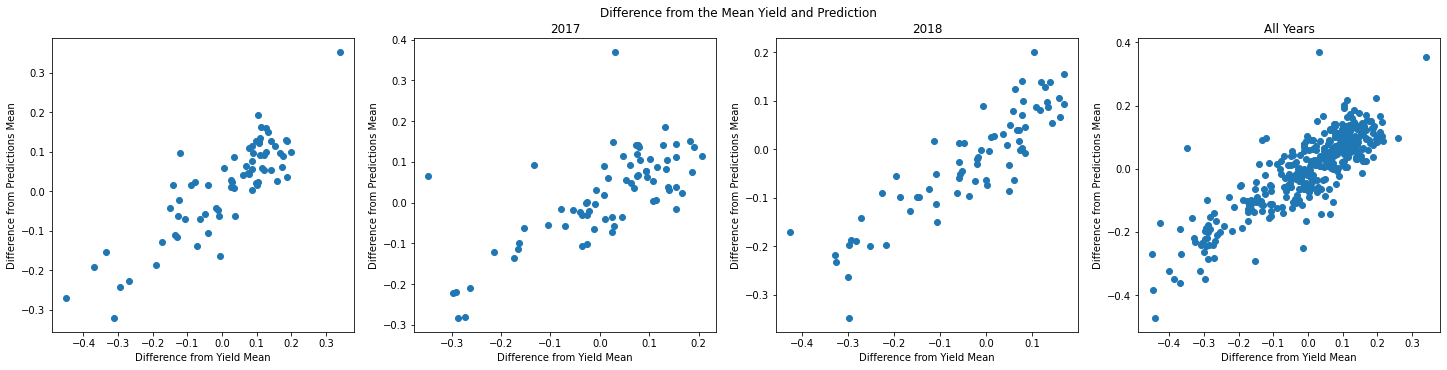

In [55]:
x1 = residual_gdf_2016["demean_yield"]
y1 = residual_gdf_2016["demean_prediction"]

x2 = residual_gdf_2017["demean_yield"]
y2 = residual_gdf_2017["demean_prediction"]

x3 = residual_gdf_2018["demean_yield"]
y3 = residual_gdf_2018["demean_prediction"]

x4 = residual_gdf["demean_yield"]
y4 = residual_gdf["demean_prediction"]

plt.subplots(figsize = (20, 5))
plt.suptitle("Difference from the Mean Yield and Prediction")
plt.tight_layout()

plt.subplot(1, 4, 1)
plt.scatter(x1, y1)
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

plt.subplot(1, 4, 2)
plt.scatter(x2, y2)
plt.title("2017")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

plt.subplot(1, 4, 3)
plt.scatter(x3, y3)
plt.title("2018")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

plt.subplot(1, 4, 4)
plt.scatter(x4, y4)
plt.title("All Years")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

In [56]:
r_squared_2016 = r2_score(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 R^2: ", r_squared_2016)
pearsonr_2016 = pearsonr(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 Pearson's: ", pearsonr_2016[0])
print("")

r_squared_2017 = r2_score(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 R^2: ", r_squared_2017)
pearsonr_2017 = pearsonr(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 Pearson's: ", pearsonr_2017[0])
print("")

r_squared_2018 = r2_score(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 R^2: ", r_squared_2018)
pearsonr_2018 = pearsonr(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 Pearson's: ", pearsonr_2018[0])
print("")

r_squared_allyrs = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years R^2: ", r_squared_allyrs)
pearsonr_allyrs = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years Pearson's: ", pearsonr_allyrs[0])

2016 R^2:  0.7357459166111255
2016 Pearson's:  0.8612025459378653

2017 R^2:  0.5027459594078955
2017 Pearson's:  0.7219061973525294

2018 R^2:  0.7607389019623575
2018 Pearson's:  0.8830808912927911

All Years R^2:  0.7180966764087349
All Years Pearson's:  0.8477586043621943
